In [1]:
# Install the pycoco library as it is not part of the Kaggle environment
!pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-5lwh7tmj
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-5lwh7tmj
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=272555 sha256=d2fbf5904e6128e28a7ffca82b8fde0b8fd31098f1dc3002a6a999a7a227daf4
  Stored in directory: /tmp/pip-ephem-wheel-cache-sccthg2o/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools


In [2]:
# Import the necessary libraries
import numpy as np
import random
import cv2
import skimage.io as io
from pycocotools.coco import COCO
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [3]:
# Define the image dataset and annotations paths
val_images_path = '../input/food-recognition-challenge/val-v0.4/val/images'
val_anns_path = '../input/food-recognition-challenge/val-v0.4/val/annotations.json'

In [4]:
# Function to load JSON into a COCO api
def getCOCO(anns_path):
    # Initialize the COCO api for instance annotations
    coco = COCO(anns_path)
    
    # Load the categories in a variable
    catIDs = coco.getCatIds()
    cats = coco.loadCats(catIDs)
    
    # Print number of categories
    nms = [cat['name'] for cat in cats]
    print('\nNumber of COCO categories: {}\n'.format(len(nms)))
    
    # Print number of instances of each category
    for i, catID in enumerate(catIDs):
        imgIds = coco.getImgIds(catIds=catID)
        print('Number of {} instances: {}'.format(nms[i], len(imgIds)))
        
    return coco

In [5]:
# Load annotations and print metadata of the image set
coco = getCOCO(val_anns_path)

loading annotations into memory...
Done (t=0.25s)
creating index...
index created!

Number of COCO categories: 273

Number of water instances: 98
Number of pear instances: 6
Number of egg instances: 30
Number of grapes instances: 3
Number of butter instances: 47
Number of bread-white instances: 65
Number of jam instances: 25
Number of bread-whole-wheat instances: 6
Number of apple instances: 38
Number of tea-green instances: 4
Number of white-coffee-with-caffeine instances: 14
Number of tea-black instances: 3
Number of mixed-salad-chopped-without-sauce instances: 28
Number of cheese instances: 22
Number of tomato-sauce instances: 14
Number of pasta-spaghetti instances: 9
Number of carrot instances: 39
Number of onion instances: 9
Number of beef-cut-into-stripes-only-meat instances: 5
Number of rice-noodles-vermicelli instances: 2
Number of salad-leaf-salad-green instances: 64
Number of bread-grain instances: 7
Number of espresso-with-caffeine instances: 16
Number of banana instances: 2

# Reference Implementation for Generator and Augmentor

https://towardsdatascience.com/master-the-coco-dataset-for-semantic-image-segmentation-part-2-of-2-c0d1f593096a

In [6]:
def filterImgs(coco, classes=None):    
    images = []
    if classes!=None:
        # Iterate for each individual class in the list
        for className in classes:
            # get all images containing given categories
            catIds = coco.getCatIds(catNms=className)
            imgIds = coco.getImgIds(catIds=catIds)
            images += coco.loadImgs(imgIds)
    
    else:
        imgIds = coco.getImgIds()
        images = coco.loadImgs(imgIds)
    
    # Now, filter out the repeated images
    unique_images = []
    for i in range(len(images)):
        if images[i] not in unique_images:
            unique_images.append(images[i])
            
    random.shuffle(unique_images)
    dataset_size = len(unique_images)
    print('Number of filtered images: {}'.format(dataset_size))
    
    return unique_images

In [7]:
def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id'] == classID:
            return cats[i]['name']
    return None

def getImage(imageObj, img_folder, input_image_size):
    # Read and normalize an image
    train_img = io.imread(img_folder + '/' + imageObj['file_name'])/255.0
    # Resize
    train_img = cv2.resize(train_img, input_image_size)
    if (len(train_img.shape)==3 and train_img.shape[2]==3): # If it is a RGB 3 channel image
        return train_img
    else: # To handle a black and white image, increase dimensions to 3
        stacked_img = np.stack((train_img,)*3, axis=-1)
        return stacked_img
    
def getMask(imageObj, classes, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    cats = coco.loadCats(catIds)
    train_mask = np.zeros(input_image_size)
    
    class_set = set()
    for a in range(len(anns)):
        className = getClassName(anns[a]['category_id'], cats)
        class_set.add(className)
        pixel_value = classes.index(className)+1
        new_mask = cv2.resize(coco.annToMask(anns[a])*pixel_value, input_image_size)
        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask, class_set 

In [8]:
def imgGenerator(coco, img_path, classes, input_image_size=(224, 224), batch_size=4):
    unique_images = filterImgs(coco, classes)
    dataset_size = len(unique_images)
    catIds = coco.getCatIds(catNms=classes)
    
    c = 0
    cats_lst = []
    while(True):
        img = np.zeros((batch_size, input_image_size[0], input_image_size[1], 3)).astype('float')
        mask = np.zeros((batch_size, input_image_size[0], input_image_size[1], 1)).astype('float')

        for i in range(c, c+batch_size): # Initially from 0 to batch_size, when c = 0
            imageObj = unique_images[i]
            
            ### Retrieve Image ###
            train_img = getImage(imageObj, img_path, input_image_size)
            
            ### Create Mask ###
            train_mask, train_cats = getMask(imageObj, classes, coco, catIds, input_image_size)                
            
            # Add to respective batch sized arrays
            img[i-c] = train_img
            mask[i-c] = train_mask
            cats_lst.append(train_cats)
            
        c+=batch_size
        if(c + batch_size >= dataset_size):
            c=0
            random.shuffle(unique_images)
            
        yield img, mask, cats_lst

In [9]:
def visualiseGen(gen):
    img, mask, cats_lst = next(gen)
    
    fig = plt.figure(figsize=(20, 10))
    outerGrid = gridspec.GridSpec(1, 2, wspace=0.1, hspace=0.1)
    
    for i in range(2):
        innerGrid = gridspec.GridSpecFromSubplotSpec(2, 2,
                        subplot_spec=outerGrid[i], wspace=0.05, hspace=0.05)

        for j in range(4):
            ax = plt.Subplot(fig, innerGrid[j])
            if(i==1):
                ax.imshow(img[j])
            else:
                ax.imshow(mask[j][:,:,0])
                
            ax.axis('off')
            for n, e in enumerate(cats_lst[j]):
                if n == 0:
                    title = 'Image {}: '.format(j) + e
                else:
                    title += ', ' + e
            ax.title.set_text(title)
            fig.add_subplot(ax)        
    
    plt.show()

Number of filtered images: 54


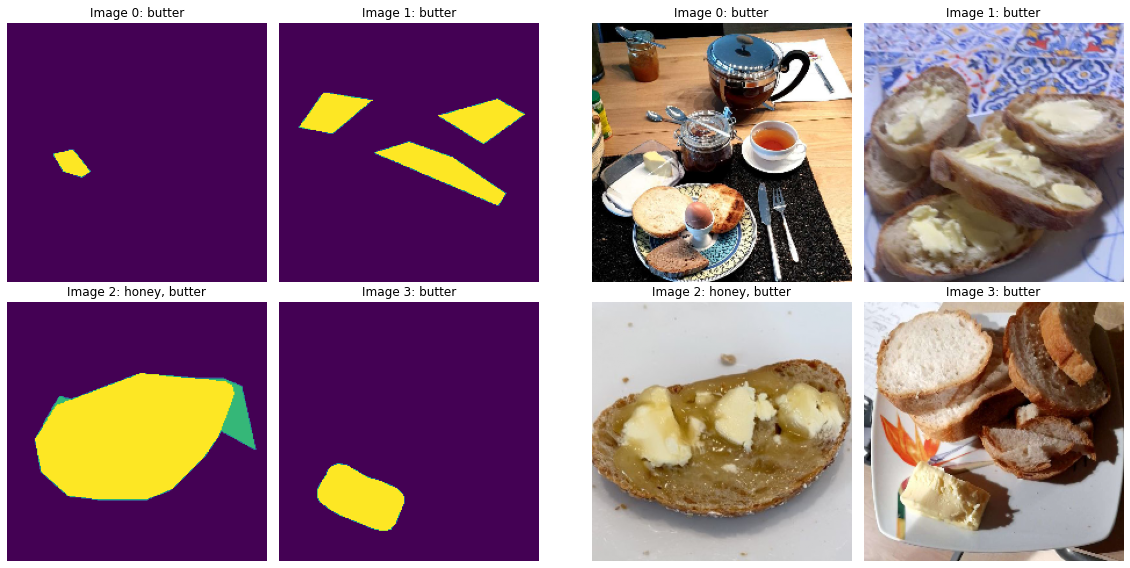

In [10]:
classes = ['bread', 'butter', 'honey']
input_image_size = (224, 224)
batch_size = 4

val_gen = imgGenerator(coco, val_images_path, classes, input_image_size, batch_size)
visualiseGen(val_gen)